In [82]:
import pandas as pd
import os
from common import data_folder_path
import matplotlib.pyplot as plt
import numpy as np


In [83]:
data_file = 'train.csv'
df = pd.read_csv(os.path.join(data_folder_path,data_file))
df['datetime'] = pd.to_datetime(df['datetime'])
df['Time of Day']=df['datetime'].dt.hour
df['Day of Week']=df['datetime'].dt.day_of_week
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,Time of Day,Day of Week
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,0,2
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,0,2
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,0,2
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,0,2
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,23,2
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,23,2
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,23,2
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,23,2


In [84]:
#based on this https://seasonsyear.com/Estonia
def get_season(row):
    month = row.month
    if month in [12,1,2,3]: #'Snow starts to fall at around middle of December and remains to mid-March. By the beginning of December temperature of water finally drops below zero (0C) thus the ice begins to appear by the coasts.'
        return 'Winter'
    elif month in [4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer' #'Climate of the summer months: ... June ... July ... August'
    else:
        return 'Autumn' #'In Estonia coming of actual Autumn is almost simultaneous to calendar change of seasons.'

df['Season'] = df['datetime'].apply(get_season)
df['Season'].value_counts()#.plot(kind='bar')
assert df['Season'].value_counts().sum()==df.shape[0] #sanity check that all rows have a season

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
results_dict = {}
coefs_dict = {}
for is_consumption in [0,1]:
    #print('is_consumption',is_consumption)
    results_dict[is_consumption] = {}
    coefs_dict[is_consumption] = {}
    for product_type in df['product_type'].unique():
        #print('product_type',product_type)
        train_cols = ['county','is_business','Time of Day','Day of Week', 'Season','target']
        train_data = df[(df['is_consumption']==is_consumption)&(df['product_type']==product_type)][train_cols].dropna()
        X,y = train_data.iloc[:,:-1],train_data.iloc[:,-1]
        
        y_ss = StandardScaler()
        y = y_ss.fit_transform(y.values.reshape(-1,1)).flatten()
        y[np.isnan(y)]
        seasons = X['Season'].astype('category')
        X['Season'] = seasons.cat.codes

        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
        lr = LinearRegression()
        lr.fit(X_train,y_train)
        y_pred = lr.predict(X_test)
        
        y_test = y_ss.inverse_transform(y_test.reshape(-1, 1))
        y_pred = y_ss.inverse_transform(y_pred.reshape(-1, 1))
        mae = mean_absolute_error(y_test,y_pred)
        coefs = list(zip(lr.coef_,lr.feature_names_in_))
        coefs_dict[is_consumption][product_type] = coefs
        results_dict[is_consumption][product_type] = mae
        #print('\n'.join(map(str,)))
#print a grid of is_consumption columns and product_type rows
results_df = pd.DataFrame.from_dict(results_dict,orient='index')
print(coefs_dict[0][3])
print(coefs_dict[1][3])
results_df
#better at prediction production than consumption (because consumption is smooth)
#best at product 2 (8/25), followed by 1 (61/135) and 0 (55/254); 3 is bad (227/863)

[(-0.015359703023658062, 'county'), (-0.05249586226612755, 'is_business'), (0.007047230295586549, 'Time of Day'), (0.012182226498399864, 'Day of Week'), (-0.04479917423055243, 'Season')]
[(-0.03946812492628079, 'county'), (0.6684202182051646, 'is_business'), (0.002708369237359535, 'Time of Day'), (-0.02508327039237401, 'Day of Week'), (0.041785302250807926, 'Season')]


,1,2,3,0
0,61.522646,8.331175,227.210556,55.787076
1,136.015741,25.857129,865.246319,248.677670


In [96]:

print(df['product_type'].value_counts(),end='\n\n')
print("product type 3:",df[df['product_type']==3]['is_business'].value_counts())
#3 is the most common product type - have the most to gain from better prediction
#the high coef for is_business on product 3 combined with the poor predictions implies 
#there is some instrumentality/overloading of the is_business flag - what is that?



product_type
3    918720
1    781632
0    170544
2    147456
Name: count, dtype: int64

product type 3: is_business
1    489984
0    428736
Name: count, dtype: int64


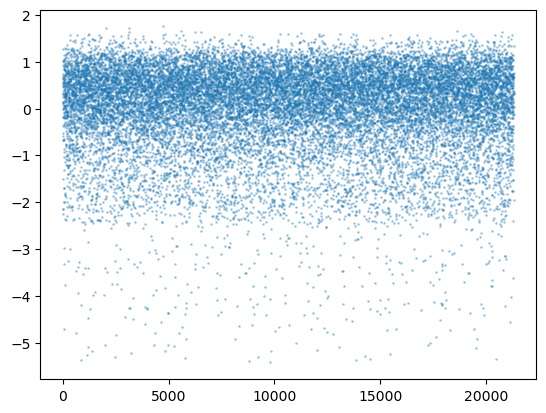

In [98]:
#show a chart of the error of each prediction, bucketed intelligently

plt.scatter(x=range(len(y_pred)),y=y_ss.transform(y_pred)-y_ss.transform(y_test),s=1,marker='o',alpha=0.3)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 1.00

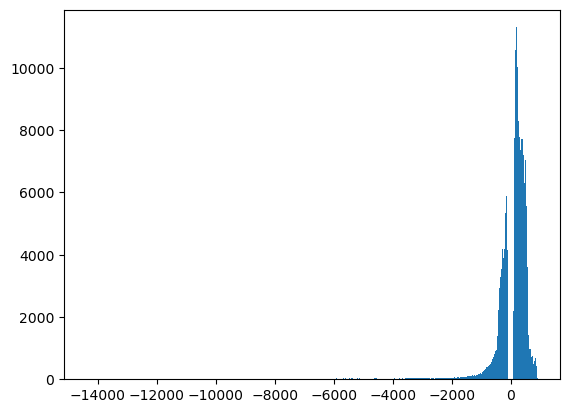

In [70]:
eps = 100
plt.hist((y_pred-y_test)[np.abs(y_pred-y_test)>eps],bins=1000)

In [71]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
df['Month'] = df.datetime.dt.month
train_cols = ['county','is_business','product_type','is_consumption','Time of Day', 'Month','target']
train_data = df[train_cols].dropna()
X,y = train_data.iloc[:,:-1],train_data.iloc[:,-1]
y_ss = StandardScaler()
y = y_ss.fit_transform(y.values.reshape(-1,1)).flatten()
y[np.isnan(y)]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
from sklearn.metrics import mean_absolute_error

y_test = y_ss.inverse_transform(y_test.reshape(-1, 1))
y_pred = y_ss.inverse_transform(y_pred.reshape(-1, 1))
print('MAE: ',mean_absolute_error(y_test,y_pred))
print('\n'.join(map(str,list(zip(lr.coef_,lr.feature_names_in_)))))


MAE:  368.1169863033782
(-0.02198378015783117, 'county')
(0.36551023917787634, 'is_business')
(0.1771520355535152, 'product_type')
(0.4080306681208522, 'is_consumption')
(0.0025524157786720038, 'Time of Day')
(-0.005386858182213619, 'Month')
